# Inspect Cyclone Training Data

Inspect and visualize data loading and pre-processing code.

In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/cyclone"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import cyclone

%matplotlib inline 

/home/vgmdaemon/projects/NN/Mask_RCNN


Using TensorFlow backend.


In [2]:
print(ROOT_DIR)

/home/vgmdaemon/projects/NN/Mask_RCNN


In [3]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

In [4]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/cyclone")

# Use configuation from nucleus.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(cyclone.CycloneConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = cyclone.CycloneConfig() #NoResizeConfig()

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

In [6]:
print(DATASET_DIR)

/home/vgmdaemon/projects/NN/Mask_RCNN/datasets/cyclone


In [7]:
# Load dataset

dataset = cyclone.CycloneDataset()
dataset.load_cyclone(DATASET_DIR, subset="val")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 10
Class Count: 2
  0. BG                                                
  1. cyclone                                           


## Display Samples

[9 4]
9 (820, 977, 1) [1]


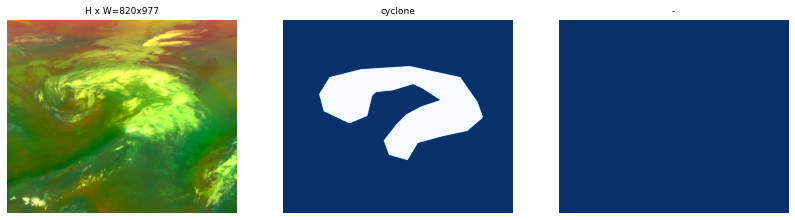

4 (957, 1024, 1) [1]


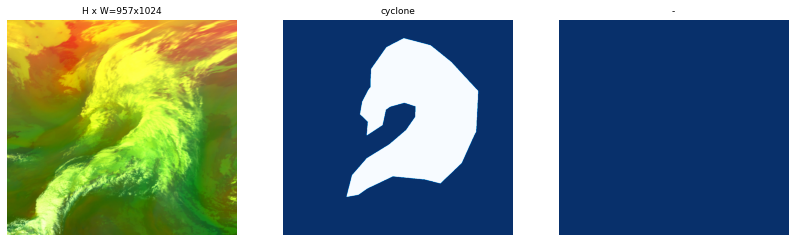

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 2)
print(image_ids)
for image_id in image_ids:
#for image_id in dataset.image_ids:    
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    print(image_id, mask.shape, class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=2)

molded_image             shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


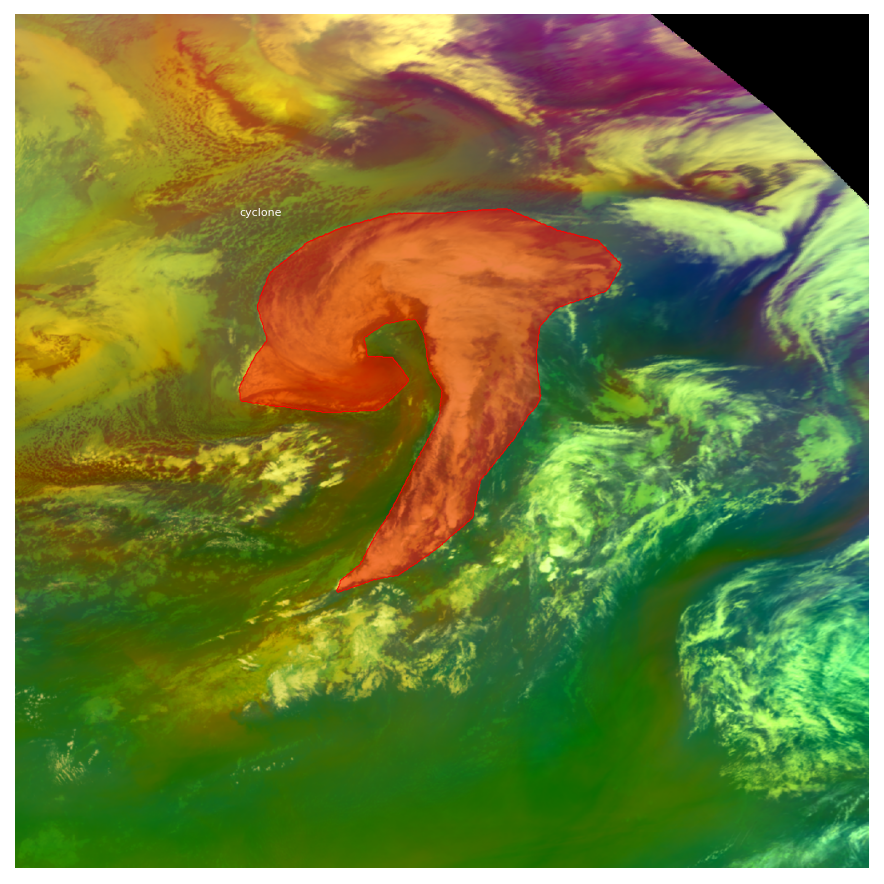

In [9]:
# Example of loading a specific image by its source ID
#source_id = "13.02.2020 09.00.png"
source_id = "30.01.2020T01.45.png"

# Map source ID to Dataset image_id
# Notice the nucleus prefix: it's the name given to the dataset in NucleusDataset
image_id = dataset.image_from_source_map["cyclone.{}".format(source_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [10]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 0.2 seconds


### Image Size Stats

Image Count:  10
Height  mean: 896.80  median: 895.50  min: 690.00  max: 1033.00
Width   mean: 1012.20  median: 1024.00  min: 959.00  max: 1024.00
Color   mean (RGB): 108.74 136.09 45.64


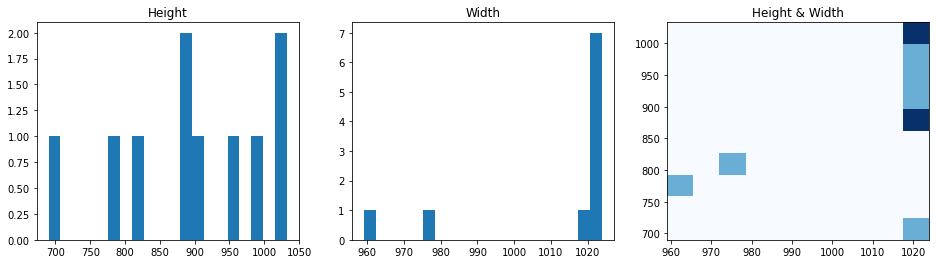

In [11]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### Cyclone per Image Stats

Cyclone/Image
Image area <= 1000**2:  mean: 1.1  median: 1.0  min: 1.0  max: 2.0
Image area <= 2000**2:  mean: 1.0  median: 1.0  min: 1.0  max: 1.0


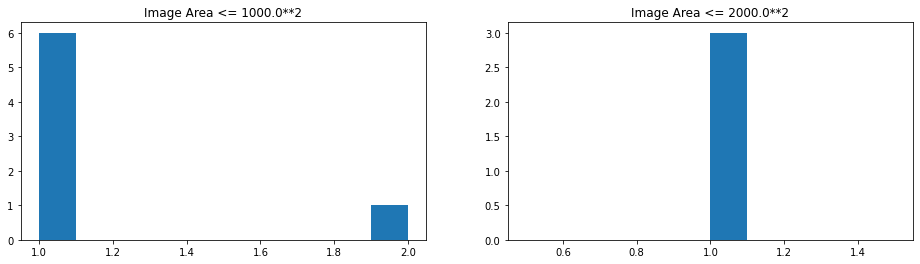

In [32]:
# Segment by image area
image_area_bins = [1000**2, 2000**2]

print("Cyclone/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nuclei_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(nuclei_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), nuclei_per_image.mean(), np.median(nuclei_per_image), 
        nuclei_per_image.min(), nuclei_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(nuclei_per_image, bins=10)

### Cyclone Size Stats


Image Area <= 1000**2
  Total Cyclone:  8
  Cyclone Height. mean: 385.25  median: 365.00  min: 238.00  max: 706.00
  Cyclone Width.  mean: 581.38  median: 602.00  min: 412.00  max: 695.00
  Cyclone Area.   mean: 228443.88  median: 224067.00  min: 102340.00  max: 413716.00

Image Area <= 2000**2
  Total Cyclone:  3
  Cyclone Height. mean: 651.67  median: 718.00  min: 460.00  max: 777.00
  Cyclone Width.  mean: 631.67  median: 662.00  min: 458.00  max: 775.00
  Cyclone Area.   mean: 427168.00  median: 514374.00  min: 210680.00  max: 556450.00


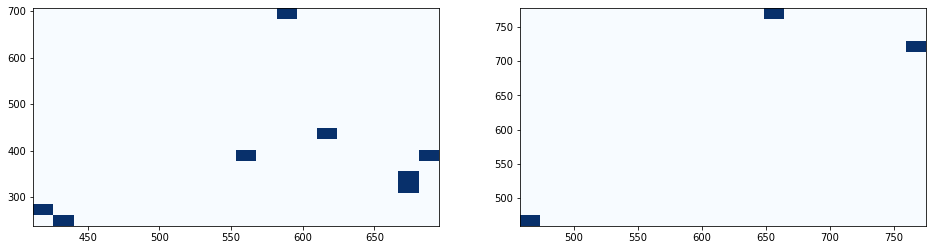

In [33]:
# Cyclone size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    cyclone_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    cyclone_area = cyclone_shape[:, 0] * cyclone_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Cyclone: ", cyclone_shape.shape[0])
    print("  Cyclone Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(cyclone_shape[:, 0]), np.median(cyclone_shape[:, 0]),
        np.min(cyclone_shape[:, 0]), np.max(cyclone_shape[:, 0])))
    print("  Cyclone Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(cyclone_shape[:, 1]), np.median(cyclone_shape[:, 1]),
        np.min(cyclone_shape[:, 1]), np.max(cyclone_shape[:, 1])))
    print("  Cyclone Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(cyclone_area), np.median(cyclone_area),
        np.min(cyclone_area), np.max(cyclone_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(cyclone_shape[:, 1], cyclone_shape[:, 0], bins=20, cmap="Blues")

Cyclone Aspect Ratio.  mean: 1.03  median: 1.00  min: 0.93  max: 1.17


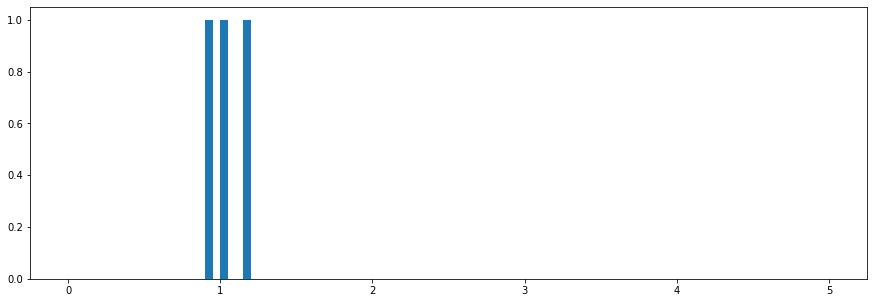

In [34]:
# Cyclone height/width ratio
cyclone_aspect_ratio = cyclone_shape[:, 0] / cyclone_shape[:, 1]
print("Cyclone Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(cyclone_aspect_ratio), np.median(cyclone_aspect_ratio),
    np.min(cyclone_aspect_ratio), np.max(cyclone_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(cyclone_aspect_ratio, bins=100, range=[0, 5])

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  6 
image                    shape: (904, 1024, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (904, 1024, 1)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:   59.00000  max:  677.00000  int32


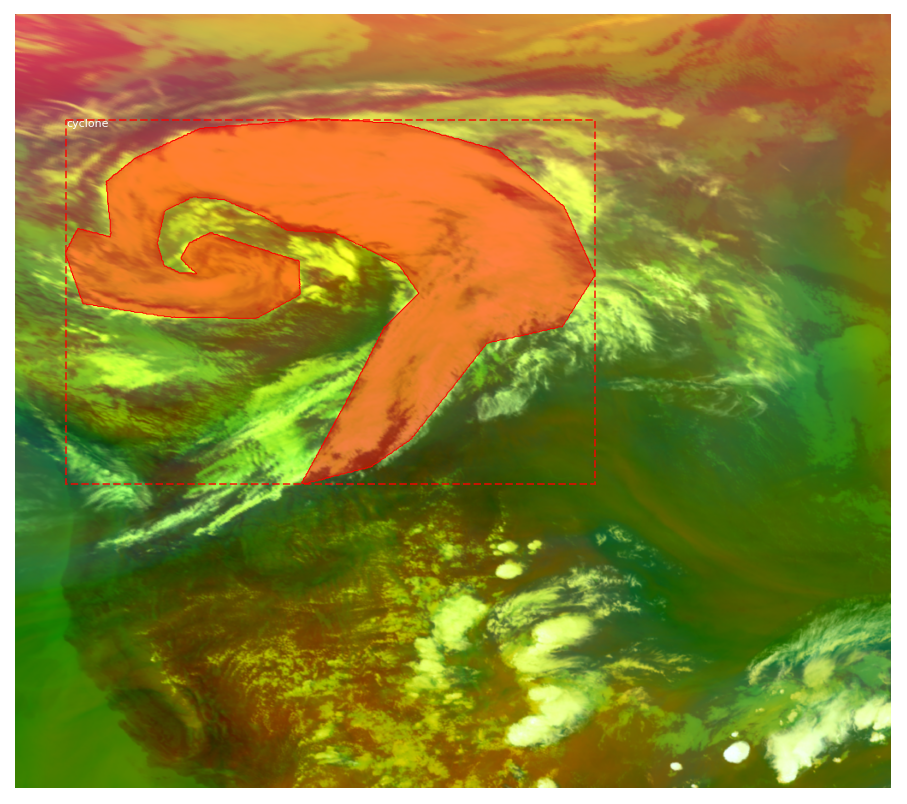

In [15]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

image_id:  7 
Original shape:  (1024, 1024, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  233.00000  max:  727.00000  int32


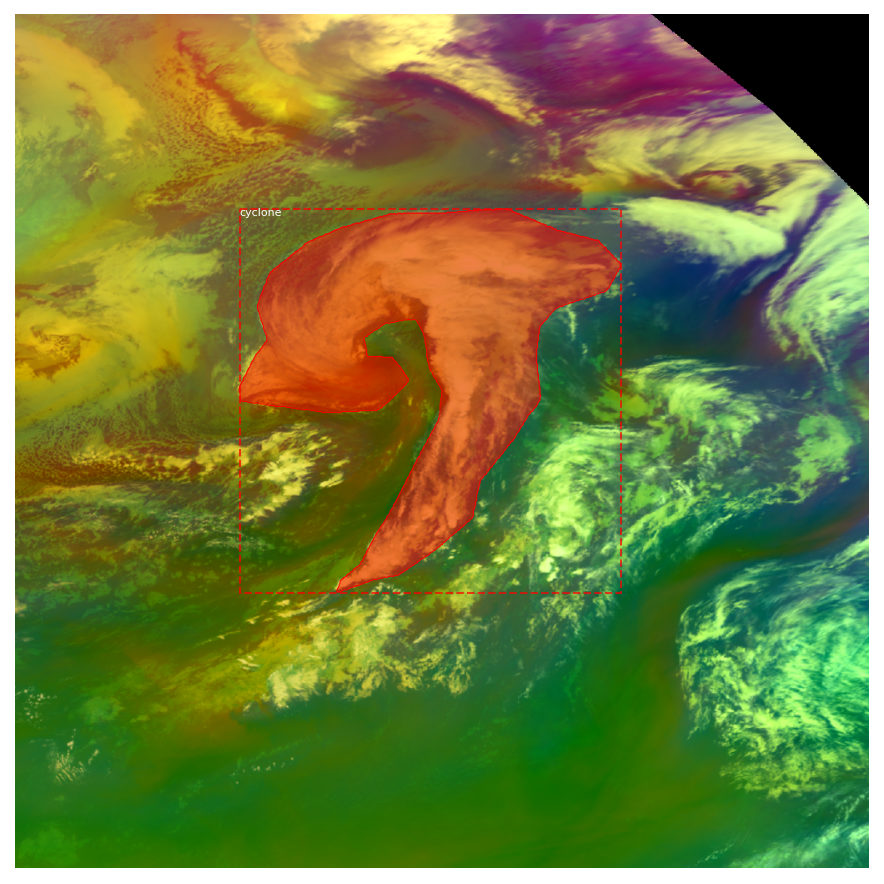

In [16]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone. 

To improve training speed, we optimize masks:
* We store mask pixels that are inside the object bounding box, rather than a mask of the full image. Most objects are small compared to the image size, so we save space by not storing a lot of zeros around the object.
* We resize the mask to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. But most object annotations are not very accuracy to begin with, so this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.

image_id:  9 
Original shape:  (820, 977, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  177.00000  max:  872.00000  int32


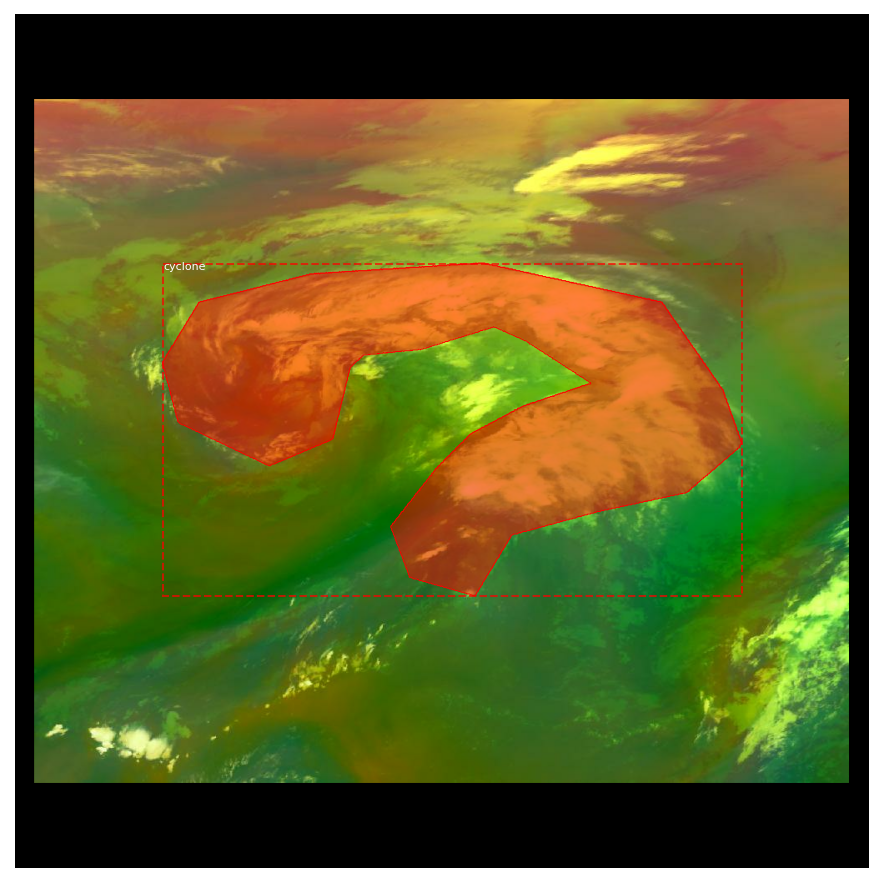

In [17]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  int64
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:  177.00000  max:  872.00000  int32
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


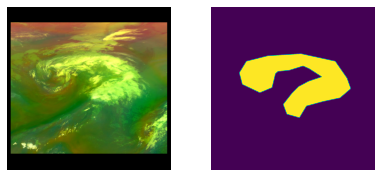

In [18]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

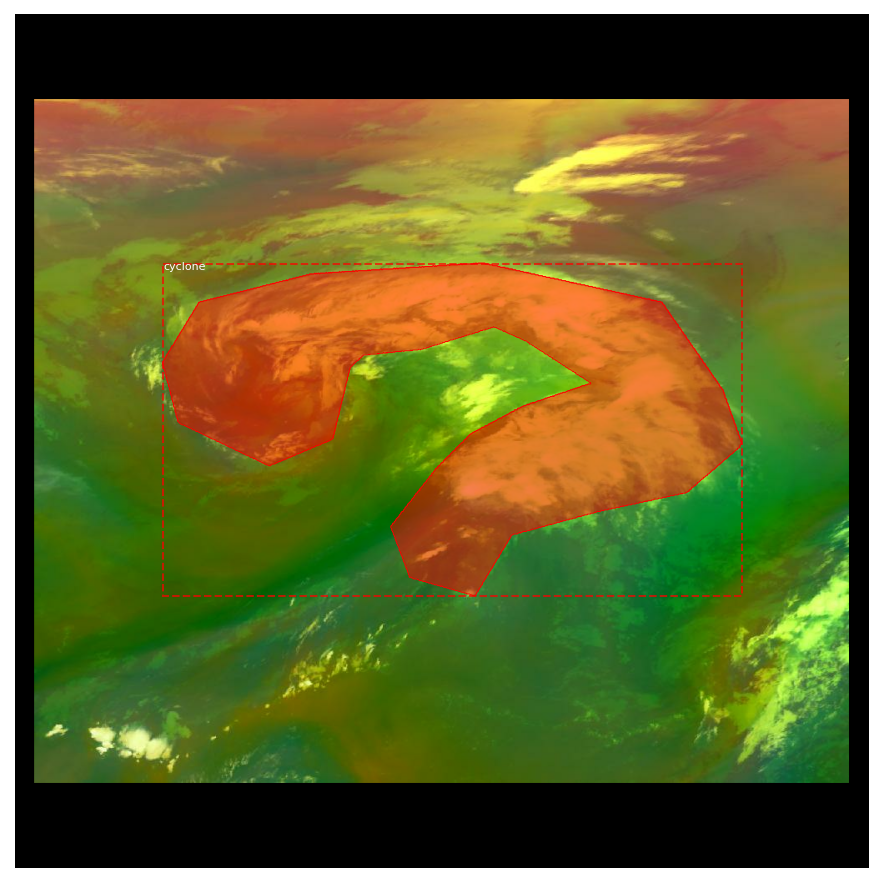

In [19]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768
Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


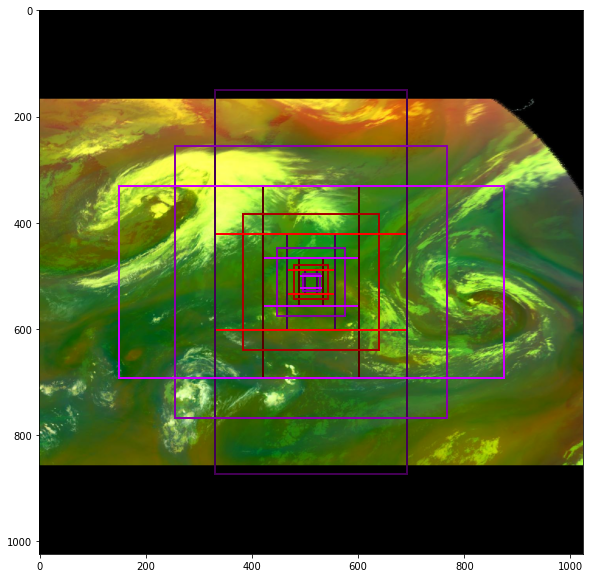

In [20]:
## Visualize anchors of one cell at the center of the feature map

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [21]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [22]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [23]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 256, 4)           min:    0.00000  max: 1023.00000  int32
mrcnn_class_ids          shape: (4, 256, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 256, 2, 4)        min:   -3.58228  max:    3.40000  float32
mrcnn_mask               shape: (4, 256, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max: 1021.00000  int32
gt_masks                 shape: (4, 256, 256, 100)    min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 128, 4)           min:   -1.37695  max:    2.37305  float64
image_id:  4 


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (3, 4)                min:  114.00000  max:  869.00000  float32
Positive anchors: 3
Negative anchors: 125
Neutral anchors: 261760
BG                     : 172
cyclone                : 84


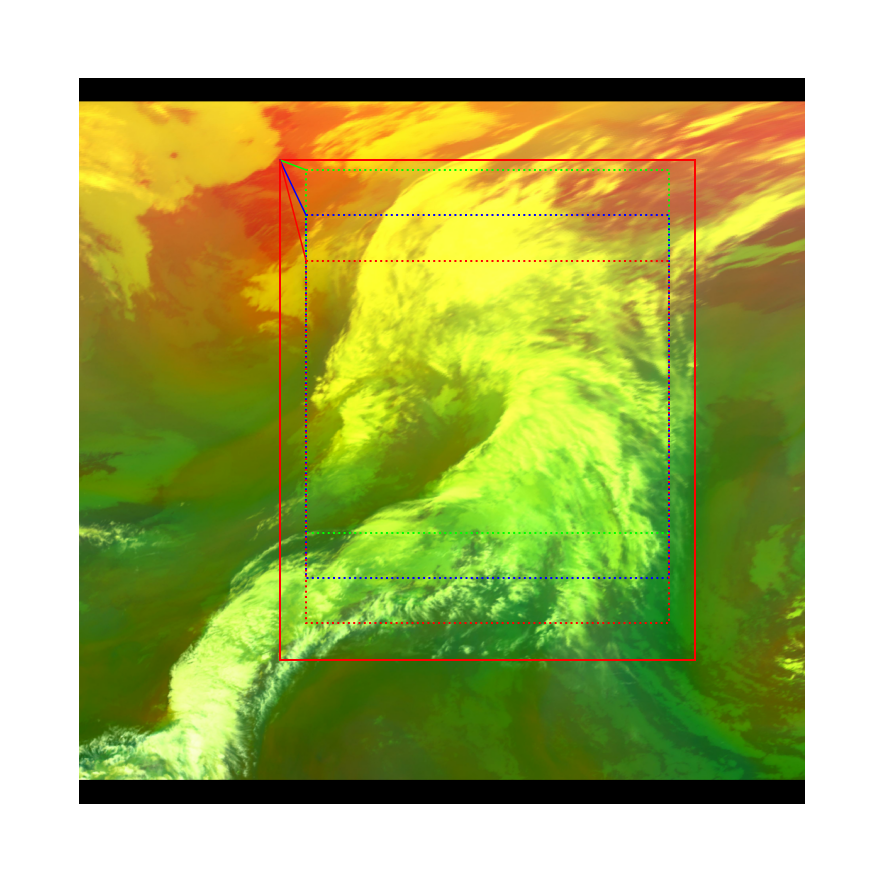

In [24]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

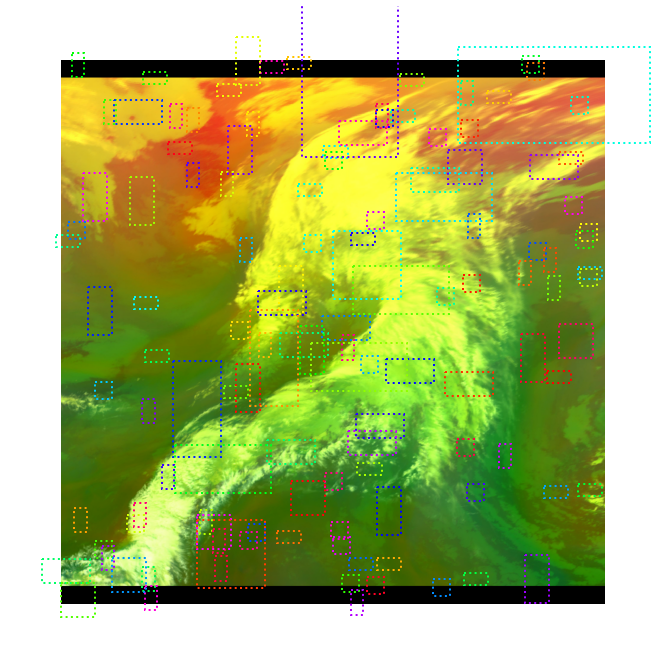

In [25]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

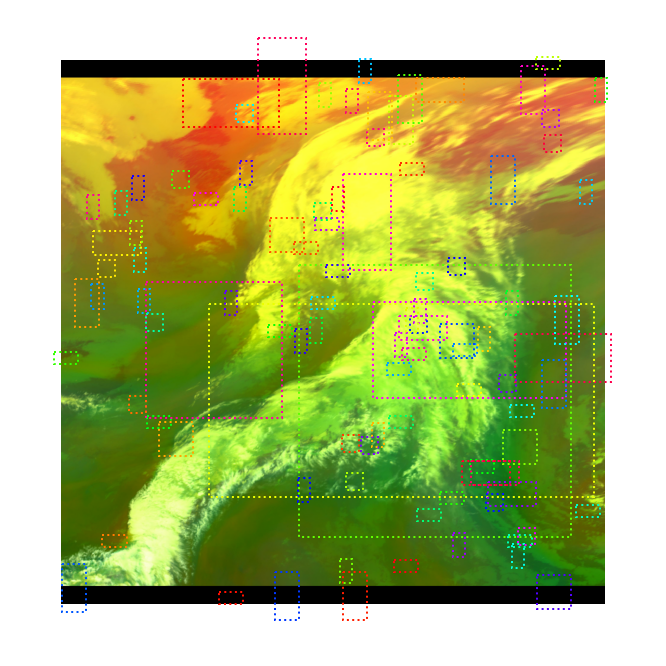

In [26]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

Positive ROIs:  84
Negative ROIs:  172
Positive Ratio: 0.33
Unique ROIs: 256 out of 256


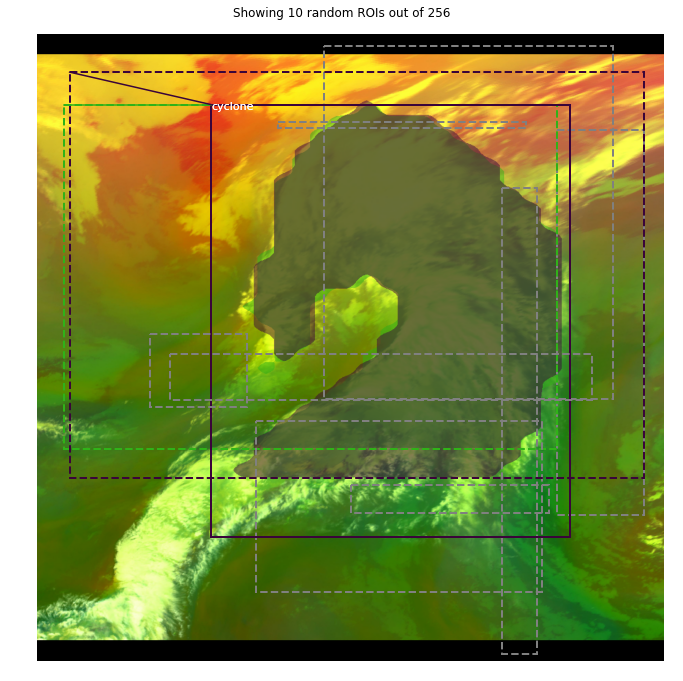

In [27]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

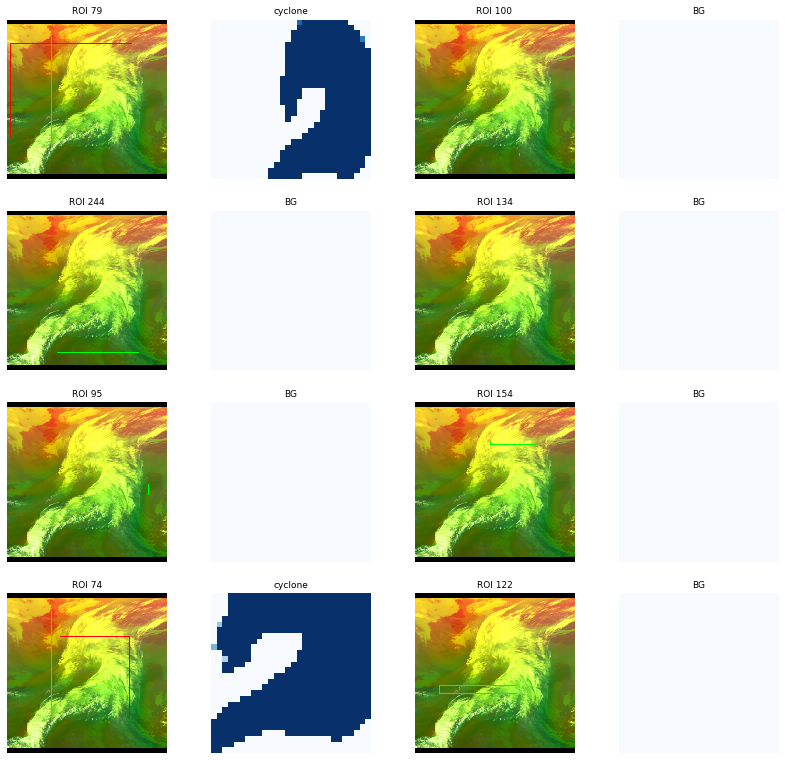

In [28]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [29]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   84  0.33
   84  0.33
   84  0.33
   84  0.33
   84  0.33
   84  0.33
   84  0.33
   84  0.33
   84  0.33
   84  0.33
Average percent: 0.33
